## 1. Set up communication with the FR3

### 1.1 Set up communication with the arm

In [1]:
%load_ext autoreload
%autoreload 2
import sys 
from FR3Py.robot.interface import FR3Real
robot = FR3Real(robot_id='fr3')

Interface Running...


In [11]:
# Print the arm state
robot.getJointStates()

{'q': array([-0.0359, -0.5479,  0.0061, -2.0954, -0.0252,  3.3507,  0.8192]),
 'dq': array([-0.0002, -0.0011,  0.0001,  0.0004,  0.0004,  0.0006,  0.    ]),
 'T': array([-0.0602, -9.9514, -0.9779, 22.2785,  0.3041,  0.9338, -0.3795]),
 'M': array([[ 0.5356, -0.0353,  0.749 ,  0.0001, -0.0704,  0.0058,  0.0042],
        [-0.0353,  2.1864, -0.0111, -1.0078, -0.0228, -0.1674,  0.0002],
        [ 0.749 , -0.0111,  1.3505, -0.0183, -0.1265,  0.0035,  0.0056],
        [ 0.0001, -1.0078, -0.0183,  0.9364,  0.0308,  0.0988, -0.0003],
        [-0.0704, -0.0228, -0.1265,  0.0308,  0.0295,  0.0033,  0.0007],
        [ 0.0058, -0.1674,  0.0035,  0.0988,  0.0033,  0.0348,  0.0002],
        [ 0.0042,  0.0002,  0.0056, -0.0003,  0.0007,  0.0002,  0.0019]]),
 'G': array([ 0.    , -9.9432, -0.5996, 21.2308,  0.8663,  1.0546, -0.0118]),
 'C': array([ 0., -0.,  0., -0., -0.,  0.,  0.])}

# 2. Go to initial joint angle

In [3]:
import numpy as np
import time

In [4]:
## Some global parameters
joint_lb = np.array([-2.3093, -1.5133, -2.4937, -2.7478, -2.48, 0.8521, -2.6895])
joint_ub = np.array([2.3093, 1.5133, 2.4937, -0.4461, 2.48, 4.2094, 2.6895])
joint_vel_lb = -np.array([2.175, 2.175, 2.175, 2.175, 2.61, 2.61, 2.61])
joint_vel_ub = np.array([2.175, 2.175, 2.175, 2.175, 2.61, 2.61, 2.61])

In [ ]:
T = 4
q_init = np.array([0.0, -0.55, 0.0, -2.10, 0.0, 3.35, 0.82])

Kp_joint = np.diag([1, 1, 1, 1, 4, 2, 1])*5
t_start = time.time()
while time.time() - t_start < T:
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    
    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_init)
    dq = - Kp_joint @ eq
    dq = np.clip(dq, joint_vel_lb, joint_vel_ub)
    robot.setCommands(dq)

robot.setCommands(np.zeros_like(dq))

# 3. uaibot

In [6]:
import uaibot as ub

##############################################################################
#Create list of obstacles
table_top = ub.Box(ub.Utils.trn([0.4,0,0.22]),width=0.32,depth=0.48,height=0.44, color='magenta')
obstacles = [table_top]

##############################################################################
#Create the robot
uai_robot = ub.Robot.create_franka_emika_3()
no_joint = np.shape(uai_robot.q)[0]

In [20]:
#CBF eta
eta = 1.5
#Convergence gain
K = 1.0
#Smoothing parameter eps for obstacle avoidance
eps_to_obs = 0.003
#Smoothing parameter h for obstacle avoidance
h_to_obs = 0.003
#Smoothing parameter eps for auto collision avoidance
eps_auto = 0.02
#Smoothing parameter h for auto collision avoidance
h_auto = 0.05
#Safety margin obstacle avoidance
d_safe_obs = 0.016
#Safety margin auto collision avoidance
d_safe_auto = 0.002
#Safety margin joint
d_safe_jl = (np.pi/180)*1
#Regularization term for the controller
eps_reg = 0.01
#Encourage to center
eps_centering = 0.01

In [18]:
# Define the time-varying trajectory
xc = 0.45
yc = 0
zc = 0.70
radius = 0.20
period = 7.0 #in seconcs
phase = np.pi/2

T_des = lambda t: ub.Utils.trn([xc, yc+radius*np.cos(2*np.pi*t/period+phase), zc+radius*np.sin(2*np.pi*t/period+phase)])*ub.Utils.roty(np.pi/2)*ub.Utils.rotz(np.pi)

In [22]:
timestamps_list = [] 
joint_angles_list = []
time_per_loop_list = []

T = 2 * period
q_mid = ((joint_ub+joint_lb)/2).reshape(-1,1)
W = np.diag(1.0/(joint_ub-joint_lb))
dt = 0.01

start_time = time.time()
while (time.time() - start_time < T):
    loop_start = time.time()
    t = loop_start - start_time
    robot_info = robot.getJointStates()
    #Get current configuration, in the real robot you have to measure this from somewhere
    q = robot_info["q"].reshape(-1,1)

    #Compute task function and Jacobian at current configuration
    #Compute the task function and its Jacobian
    r , jac_r = uai_robot.task_function(q=q, htm_des=T_des(t))

    #Compute the task feedforward numerically: partial r(q,t)/partial t
    r_next , _ = uai_robot.task_function(q=q, htm_des=T_des(t+dt))
    r_prev , _ = uai_robot.task_function(q=q, htm_des=T_des(t-dt))
    ff = (r_next-r_prev)/(2*dt)
    
    #GATHER DATA FOR THE OBSTACLE AVOIDANCE CONSTRAINT
    #Loop all the obstacles and compute distance info
    #Collect the matrices A_obs and b_obs:
    # A_obs: each line has the smooth metric gradient (in configuration space), as a row matrix,
    #        from an object of the robot and an object of the obstacle
    # b_obs: each line has the smooth metric
    A_obs = np.matrix(np.zeros((0,no_joint)))
    b_obs = np.matrix(np.zeros((0,1)))
    
    for obs in obstacles:
        dist_info = uai_robot.compute_dist(obj = obs, q=q, h=h_to_obs, eps = eps_to_obs)

        A_obs = np.vstack((A_obs, dist_info.jac_dist_mat))
        b_obs = np.vstack((b_obs, dist_info.dist_vect))
        
    #GATHER DATA FOR THE JOINT LIMIT AVOIDANCE COINSTRANT
    q_min = uai_robot.joint_limit[:,0]
    q_max = uai_robot.joint_limit[:,1]
    A_joint = np.matrix(np.vstack(  (np.identity(7), -np.identity(7))  ))
    b_joint = np.matrix(np.vstack(  (q-q_min , q_max - q)  ))
    
    #GATHER DATA FOR THE AUTO COLLISION AVOIDANCE CONSTRAINT
    dist_info =uai_robot.compute_dist_auto(q = q, eps=eps_auto, h=h_auto)
    #We can safely ignore the last four collisions, that is why we have the [0:-4,:]   
    A_auto = dist_info.jac_dist_mat[0:-4,:]
    b_auto = dist_info.dist_vect[0:-4,:]    
    
    #CREATE THE QUADRATIC PROGRAM    
    H_mat = jac_r.transpose()*jac_r + eps_centering * W @ W
    f_mat = jac_r.transpose() * (K*r+ff) - eps_centering * W @ q_mid
    
    A_mat = np.vstack((A_obs,A_joint,A_auto))
    b_mat = np.vstack( (b_obs-d_safe_obs, b_joint-d_safe_jl, b_auto-d_safe_auto) )
    
    b_mat = -eta*b_mat
        
    #Compute qdot
    dq = ub.Utils.solve_qp(H_mat, f_mat, A_mat, b_mat)
    dq = np.array(dq)
    dq = dq.squeeze(-1)
    dq = np.clip(dq, joint_vel_lb, joint_vel_ub)
    robot.setCommands(dq)
    loop_end = time.time()

    timestamps_list.append(loop_start)
    joint_angles_list.append(robot_info["q"].copy())
    time_per_loop_list.append(loop_end-loop_start)

robot.setCommands(np.zeros_like(dq))
    

# 4. Save the data

In [23]:
import pickle
from datetime import datetime
import os

now = datetime.now()
formatted_date_time = now.strftime("%Y-%m-%d-%H-%M-%S")

directory = f"exp2_results/{formatted_date_time}"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the file path
file_path = os.path.join(directory, "data.pickle")

# Data to be saved
data = {
    "q": joint_angles_list,
    "timestamp": timestamps_list,
    "time_per_loop": time_per_loop_list
}

# Save the data using pickle
with open(file_path, "wb") as f:
    pickle.dump(data, f)

# 5. Visualization

In [24]:
import matplotlib.pyplot as plt

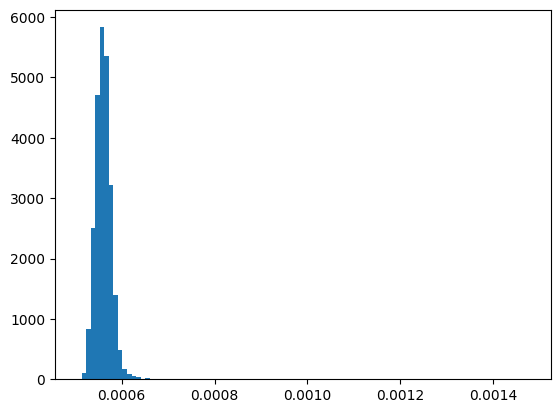

In [25]:
time_per_loop_np = np.array(time_per_loop_list)
plt.hist(time_per_loop_np, bins=100)
plt.show()